In [43]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import glob
from collections import defaultdict

In [44]:
text_list = []
counter =defaultdict(int)
for file in glob.glob('../input/cityofla/CityofLA/Job Bulletins/*'):
    f = open(file)
    try:
        text = f.readlines()
    except:
        f.close()
        continue
    func = lambda x:(x!='\n')&(x!=' \n')&(x!='\t\n')
    text = list(filter(func,text))
    for line in text:
        counter[line]+=1
    text_list.append(text)
    f.close()

In [45]:
dic = {}
key_words = []
for key in counter:
    if counter[key]>50:
        dic[key] = counter[key]
        key_words.append(key)

In [46]:
key_words = list(filter(lambda x: len(x)<100,key_words))

In [47]:
text = text_list[0]

In [48]:
def format_feature_name(x):
    x = x.replace('\n','')
    if x[-1]==' ':
        x = x[:-1]
    return x

In [49]:
features_dict_list = []
for text in text_list:
    features_dict = defaultdict(str)
    features_dict['title'] = text[0]
    for i, line in enumerate(text[:-1]):
        if line in key_words:
            features_dict[format_feature_name(text[i])] += '\n' + text[i+1]
    features_dict_list.append(features_dict)

In [50]:
df = pd.DataFrame(features_dict_list)

In [51]:
def c(text):
    rx = re.compile('([&#])')
    text = rx.sub(r'\\\1', text)

In [52]:
def get_salaries(x):
    char_list = ['\n',',',' to ',' ',';','and']
    numbers = re.sub("|".join(char_list), "", str(x)).split('$')[1:]
    numbers = map(lambda x: re.sub('[^0-9]', '', x),numbers)
    numbers = list(map(float,numbers))
#     return list(zip(numbers[0::2],numbers[1::2]))
    if len(numbers)!=0:
        return np.mean(numbers)



In [53]:
df['SALARY'] = df['ANNUAL SALARY'].apply(get_salaries)

In [54]:
months = ['JANUARY',
'FEBRUARY',
'MARCH',
'APRIL',
'MAY',
'JUNE',
'JULY',
'AUGUST',
'SEPTEMBER',
'OCTOBER',
'NOVEMBER',
'DECEMBER']

In [55]:
def get_date_list(x):
    return list(filter(lambda x: x!='',re.sub("|".join(['\.',',','\n']), " ", str(x)).split(' ')))[-3:]

In [56]:
df['date_in_list'] = df['APPLICATION DEADLINE'].apply(get_date_list)

In [57]:
df['date_in_list'].iloc[0]

['NOVEMBER', '8', '2018']

In [58]:
def get_date(date_in_list):
    if len(date_in_list)==3:
        if date_in_list[0] in months:
            return '-'.join([str(date_in_list[2]), str(months.index(date_in_list[0])+1), str(date_in_list[1])])

In [59]:
df['application_deadline'] = pd.to_datetime(df['date_in_list'].apply(get_date))

In [60]:
df_result = df[['title', 'SALARY', 'application_deadline']]

In [61]:
df_result = df_result.dropna()

In [62]:
filt1 = df_result['SALARY']<np.percentile(df_result['SALARY'], 95)
filt2 = df_result['application_deadline']>pd.Timestamp(2013,1,1)
df_result = df_result[filt1&filt2].copy()

In [63]:
els  = []
for el in df_result['title'].apply(lambda x: x.replace('\n','').split(' ')).values:
    els+=el

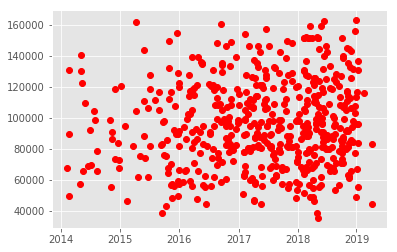

In [64]:
plt.plot(df_result['application_deadline'].dt.date,
         df_result['SALARY'],'ro')
plt.show()

In [65]:
pd.Series(els).value_counts()[:5]

              303
SENIOR         86
SUPERVISOR     85
ENGINEER       34
CHIEF          28
dtype: int64

In [66]:
key_words = ['SENIOR','SUPERVISOR','CHIEF']

In [67]:
for key_word in key_words:
    df_result[key_word] = df_result['title'].apply(lambda x: key_word in x)

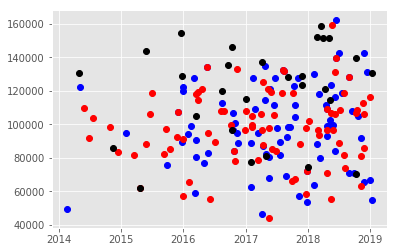

In [68]:
plt.plot(df_result[df_result['SENIOR']]['application_deadline'].dt.date,
         df_result[df_result['SENIOR']]['SALARY'],'ro',c='b')
plt.plot(df_result[df_result['SUPERVISOR']]['application_deadline'].dt.date,
         df_result[df_result['SUPERVISOR']]['SALARY'],'ro',c='r')
plt.plot(df_result[df_result['CHIEF']]['application_deadline'].dt.date,
         df_result[df_result['CHIEF']]['SALARY'],'ro',c='black')
plt.show()